<a href="https://colab.research.google.com/github/nikhil-bhargava/cv-mask-detection/blob/main/notebooks/Facemask_and_Drinking_detection_logistic_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Logistic Regression Model for Facemask Detection

In [ ]:
import os
import numpy as np
import pandas as pd
import torch
from torchvision import datasets, transforms
import torchvision
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.tensorboard import SummaryWriter
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torchsummary import summary
import urllib.request
import zipfile
import pickle

import seaborn as sns
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import PrecisionRecallDisplay

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)

%load_ext tensorboard

%matplotlib inline

torch:  1.10 ; cuda:  cu111


### Load Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/MyDrive/AIPI/AIPI\ 540:\ Deep\ Learning\ Applications/CV\ Module\ Project/downloads/

Mounted at /content/gdrive
/content/gdrive/MyDrive/AIPI/AIPI 540: Deep Learning Applications/CV Module Project/downloads


### Data Transformation

In [ ]:
data_dir_drink = "/content/gdrive/MyDrive/AIPI/AIPI 540: Deep Learning Applications/CV Module Project/downloads/yolo_dataset/drinking"
data_dir_face = "/content/gdrive/MyDrive/AIPI/AIPI 540: Deep Learning Applications/CV Module Project/downloads/yolo_dataset/facemask_data"

# Set up transformations for training and validation (test) data
# For training data we will do randomized cropping to get to 224 * 224, randomized horizontal flipping, and normalization
# For test set we will do only center cropping to get to 224 * 224 and normalization
data_transforms = {
    'train': transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485], [0.229])
    ]),
    'val': transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485], [0.229])
    ]),
}


####### Drinking ########
# Create Datasets for training and validation sets
train_dataset_drink = datasets.ImageFolder(os.path.join(data_dir_drink, 'train'),
                                          data_transforms['train'])
val_dataset_drink = datasets.ImageFolder(os.path.join(data_dir_drink, 'val'),
                                          data_transforms['val'])

# Create DataLoaders for training and validation sets
batch_size = len(train_dataset_drink)
train_loader_drink = torch.utils.data.DataLoader(train_dataset_drink, batch_size=batch_size,
                                             shuffle=True, num_workers=4)
val_loader_drink = torch.utils.data.DataLoader(val_dataset_drink, batch_size=batch_size,
                                             shuffle=False, num_workers=4)

# Set up dict for dataloaders
dataloaders = {'train':train_loader_drink,'val':val_loader_drink}
# Store size of training and validation sets
dataset_sizes = {'train':len(train_dataset_drink),'val':len(val_dataset_drink)}
# Get class names associated with labels
class_names_drink = train_dataset_drink.classes


####### Face mask ########
# Create Datasets for training and validation sets
train_dataset_face = datasets.ImageFolder(os.path.join(data_dir_face, 'train'),
                                          data_transforms['train'])
val_dataset_face = datasets.ImageFolder(os.path.join(data_dir_face, 'val'),
                                          data_transforms['val'])

# Create DataLoaders for training and validation sets
batch_size_face = len(train_dataset_face)
train_loader_face = torch.utils.data.DataLoader(train_dataset_face, batch_size=batch_size_face,
                                             shuffle=True, num_workers=4)
val_loader_face = torch.utils.data.DataLoader(val_dataset_face, batch_size=batch_size_face,
                                             shuffle=False, num_workers=4)

# Set up dict for dataloaders
dataloaders_face = {'train':train_loader_face,'val':val_loader_face}
# Store size of training and validation sets
dataset_sizes_face = {'train':len(train_dataset_face),'val':len(val_dataset_face)}
# Get class names associated with labels
class_names_face = train_dataset_face.classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
####### Drinking ########
images_drink, labels_drink = iter(train_loader_drink).next()
test_images_drink, test_labels_drink = iter(val_loader_drink).next()

# Convert to numpy arrays to train the LR model
X_drink = torch.flatten(images_drink, start_dim=1)
X_drink = X_drink.numpy()
y_drink = labels_drink.numpy()

# Test set
X_test_drink = torch.flatten(test_images_drink, start_dim=1)
X_test_drink = X_test_drink.numpy()
y_test_drink = test_labels_drink.numpy()



####### Face mask ########
images_face, labels_face = iter(train_loader_face).next()
test_images_face, test_labels_face = iter(val_loader_face).next()

# Convert to numpy arrays to train the LR model
X_face = torch.flatten(images_face, start_dim=1)
X_face = X_face.numpy()
y_face = labels_face.numpy()

# Test set
X_test_face = torch.flatten(test_images_face, start_dim=1)
X_test_face = X_test_face.numpy()
y_test_face = test_labels_face.numpy()


In [ ]:
####### Drinking ########
classes_drink = class_names_drink
nclasses_drink = len(classes_drink)

####### Face mask ########
classes_face = class_names_face
nclasses_face = len(classes_face)

In [ ]:
####### Drinking ########
#scaling the features
X_train_scaled_drink = X_drink/255.0
X_test_scaled_drink = X_test_drink/255.0

####### Face mask ########
X_train_scaled_face = X_face/255.0
X_test_scaled_face = X_test_face/255.0

In [ ]:
####### Drinking ########
clf = LogisticRegression(penalty='none', 
                         tol=0.1, solver='saga',
                         multi_class='multinomial').fit(X_train_scaled_drink, y_drink)

# save the model to disk
filename_drink = 'lr_drink.sav'
pickle.dump(clf, open(filename_drink, 'wb'))

# load the model from disk
#clf = pickle.load(open(filename_drink, 'rb'))

#to check the shape of the coefficient matrix
clf.coef_.shape

(1, 50176)

In [ ]:
####### Face mask ########
clf_face = LogisticRegression(penalty='none', 
                         tol=0.1, solver='saga',
                         multi_class='multinomial').fit(X_train_scaled_face, y_face)

# save the model to disk
filename_face = 'lr_face.sav'
pickle.dump(clf_face, open(filename_face, 'wb'))

# load the model from disk
#clf_face = pickle.load(open(filename_face, 'rb'))

#to check the shape of the coefficient matrix
clf_face.coef_.shape

(1, 50176)

In [ ]:
####### Drinking ########
z = [ clf.intercept_[k] + np.dot(clf.coef_[k], X_test_scaled_drink[k]) for k in range(1) ]

#conditional probability
exps = [np.exp(z[k]) for k in range(1)]
exps_sum = np.sum(exps)
probs = exps/exps_sum


####### Face mask ########
z_face = [ clf_face.intercept_[k] + np.dot(clf_face.coef_[k], X_test_scaled_face[k]) for k in range(1) ]

#conditional probability
exps_face = [np.exp(z_face[k]) for k in range(1)]
exps_sum_face = np.sum(exps_face)
probs_face = exps_face/exps_sum_face

In [ ]:
####### Drinking ########
#predictied label
idx_cls = np.argmax(probs)

#prediction probabilities
y_pred_prob_drink = clf.predict_proba(X_test_scaled_drink)

#predicted label
y_pred_drink = clf.predict(X_test_scaled_drink)


####### Face mask ########
#predictied label
idx_cls_face = np.argmax(probs_face)

#prediction probabilities
y_pred_prob_face = clf_face.predict_proba(X_test_scaled_face)

#predicted label
y_pred_face = clf_face.predict(X_test_scaled_face)

In [ ]:
####### Drink ########
accuracy =  np.mean(y_test_drink == y_pred_drink)
print("Drink accuracy :", accuracy)

####### Face mask ########
accuracy_face =  np.mean(y_test_face == y_pred_face)
print("Face mask accuracy :", accuracy_face)

Drink accuracy : 0.625
Face mask accuracy : 0.515625


In [ ]:
from sklearn.metrics import precision_recall_curve

####### Drink ########
precision, recall, thresholds = precision_recall_curve(y_test_drink, y_pred_drink)

####### Face mask ########
precision, recall, thresholds = precision_recall_curve(y_test_face, y_pred_face)


Proportion of Drinking (positive) Class : 0.5


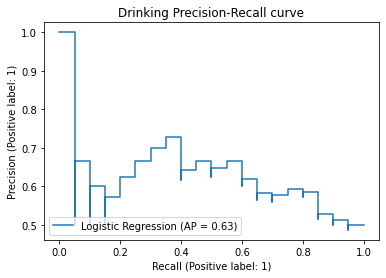

In [ ]:
####### Drink ########
display = PrecisionRecallDisplay.from_estimator(clf, X_test_scaled_drink, y_test_drink, name="Logistic Regression")
_ = display.ax_.set_title("Drinking Precision-Recall curve")

print("Proportion of Drinking (positive) Class :", np.sum(y_test_drink)/len(y_test_drink))

Proportion of Face Mask (positive) Class : 0.375


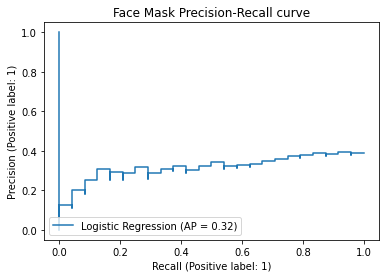

In [ ]:
####### Face mask ########
display = PrecisionRecallDisplay.from_estimator(clf_face, X_test_scaled_face, y_test_face, name="Logistic Regression")
_ = display.ax_.set_title("Face Mask Precision-Recall curve")

print("Proportion of Face Mask (positive) Class :", np.sum(y_test_face)/len(y_test_face))


**Drinking classes:** \\
0 = not drinking \\
1 = drinking

**Face mask classes:** \\
0 = no mask \\
1 = mask


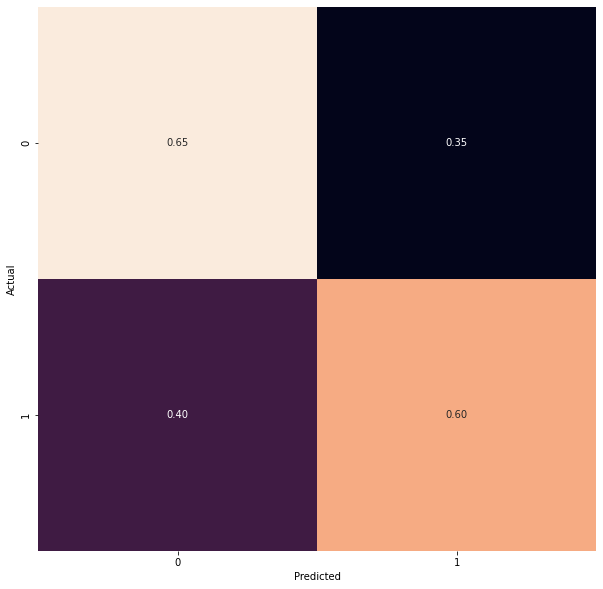

In [ ]:
####### Drink ########
cm = pd.crosstab(y_test_drink, y_pred_drink, 
                               rownames=['Actual'], colnames=['Predicted'], normalize='index')
p = plt.figure(figsize=(10,10));
p = sns.heatmap(cm, annot=True, fmt=".2f", cbar=False)

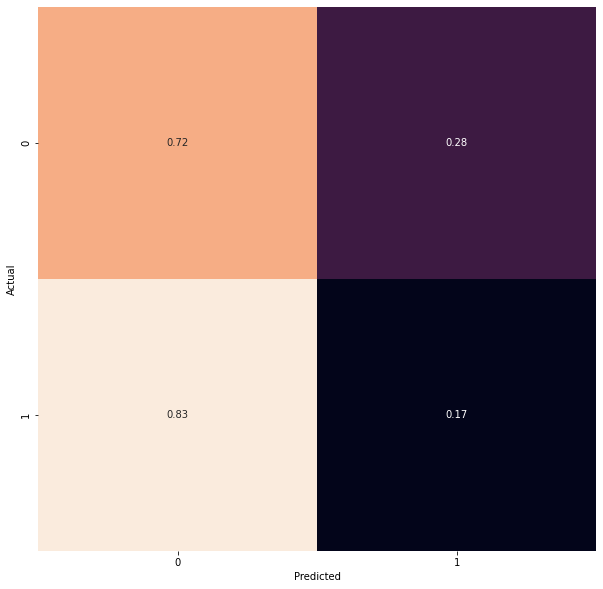

In [ ]:
####### Face mask ########
cm_face = pd.crosstab(y_test_face, y_pred_face, 
                               rownames=['Actual'], colnames=['Predicted'], normalize='index')
p_face = plt.figure(figsize=(10,10));
p_face = sns.heatmap(cm_face, annot=True, fmt=".2f", cbar=False)